In [1]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sb
import os
import re
import scipy.stats as st
%matplotlib inline
plt.style.use('ggplot')


In [2]:
sb.set_style("whitegrid")
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["grid.linewidth"] = 2.0
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.1
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"]= 0.9
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["figure.titlesize"] = 16
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = False
pd.options.display.max_columns = 1000

In [3]:
os.chdir("../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/MALARIA/"

In [4]:
# Esto no incluye toda las áreas del país. Sólo las áreas vistas en la base de datos de notifs.
notifs_das2depto = {
    "Escuintla": 5,
    "Alta Verapaz": 16,
    "Izabal" : 18,
    "Suchitepéquez" : 10,
    "Suchitepequez" : 10,
    "Santa Rosa" : 6,
    "Retalhuleu" : 11,
    "Petén Norte" : 17,
    "Peten Norte": 17,
    "Petén SurOccidente" : 17,
    "Petén SurOccidental" : 17,
    "Peten SurOriente" : 17,
    "Huehuetenango" : 13,
    "Quiché" : 14,
    "El Quiché": 14,
    "Petén Sur Oriental" : 17,
    "Baja Verapaz" : 15,
    "Sololá" : 7,
    "Zacapa" : 18,
    "Ixcán" : 14,
    "San Marcos" : 12,
    "Chimaltenango" : 4,
    "Guatemala Central" : 1,
    "Guatemala Sur" : 1,
    "Guatemala Nororiente" : 1,
    "Guatemala Noroccidente" : 1,
    "Ixil" : 14,
    "Jutiapa" : 22,
    "Chiquimula" : 20,
    "Ixcan" : 14,
    "El Progreso" : 2,
    "Guatemala Nororiental" : 1,
    "Quetzaltenango" : 9,
    "Jalapa": 21,
    "LNS": 1
}
code2depto = {
    5: "Escuintla",
    16:"Alta Verapaz",
    18: "Izabal",
    10: "Suchitepéquez",
    6: "Santa Rosa",
    11: "Retalhuleu",
    17: "Petén",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    7: "Sololá",
    18: "Zacapa",
    12: "San Marcos",
    4: "Chimaltenango",
    1: "Guatemala",
    22: "Jutiapa",
    20: "Chiquimula",
    2: "El Progreso",
    9: "Quetzaltenango",
    3: "Sacatepequez",
    21: "Jalapa"
}

In [5]:
bednets = pd.read_csv(base_dir + "GTM - Bednets Distr.csv", index_col = 0 , low_memory=False)
notifs = pd.read_excel(base_dir + "Base de datos 2016 - 2018 NAD.xlsx")

In [6]:
notifs = pd.read_csv("../../Outcome Measurement Data/MALARIA/Malaria-Gt-NAD2019.csv", index_col=0)

In [7]:
pdr = pd.read_excel(base_dir + "Movimientos MTILD y  PDR PERIODO FASE II.xls", 3, skiprows=2)
pdr.columns = ["das", 2015,2016,2017]
pdr["deptocode"] = pdr.das.apply(lambda x: notifs_das2depto.get(x.strip() if type(x) == str else "", np.NaN))
pdr = pdr.groupby("deptocode")[[2015,2016, 2017]].sum()

In [8]:
notifs.columns

Index(['AREA', 'DISTRITO', 'LOCALIDAD', 'EDAD', 'GENERO',
       'FECHA INICIO SINTOMAS', 'FECHA TOMA DE MUESTRA',
       'FECHA RECEPCIÓN LABORATORIO', 'FECHA DE DIANÓSTICO',
       'INICIO TRATAMIENTO', 'FIN DE TRATAMIENTO', 'TIPO MALARIA',
       'SEMANA EPIDEMIOLÓGICA', 'TIPO DE MUESTRA', 'EMBARAZADA',
       'DENSIDAD PARASITARIA', 'Gametocitos', 'EMBARAZADA.1', 'Sintytom',
       'tomydiag', 'diagytrat', 'sinytrat', 'Año', 'Sintydiag', 'NOMBRE_HASH'],
      dtype='object')

In [9]:
notifs = notifs[notifs.AREA.notna()]

In [10]:
def clean(x):
    try: 
        return x.strip().lower()
    except:
        return np.NaN
notifs["deptocode"] = notifs.AREA.map(str.strip).map(notifs_das2depto.get)
notifs["GENERO"] = notifs["GENERO"].apply(clean)
notifs["Gender"] = notifs.GENERO.map(lambda x: "Male" if x == "m" else "Female" if x == "f" else np.NaN)
notifs["Year"] = pd.to_datetime(notifs["FECHA TOMA DE MUESTRA"]).map(lambda y: y.year)

In [11]:
a = notifs.groupby(["AREA", "Year"]).apply(len).unstack(1)
a, a.sum()

(Year                   2014.0  2015.0  2016.0  2017.0  2018.0  2019.0
 AREA                                                                 
 Alta Verapaz              NaN   798.0   544.0   751.0   787.0   124.0
 Baja Verapaz              NaN    20.0     8.0    10.0     6.0     NaN
 Chimaltenango             NaN    11.0     3.0     2.0     1.0     NaN
 Chiquimula                NaN     3.0     1.0     2.0     9.0     NaN
 El Progreso               NaN     2.0     NaN     2.0     NaN     NaN
 Escuintla                 1.0  3585.0  3198.0  2438.0  1563.0   741.0
 Guatemala Central         NaN     1.0     5.0     6.0     5.0     NaN
 Guatemala Nororiental     NaN     1.0     2.0     1.0     NaN     NaN
 Guatemala Sur             NaN     1.0     4.0     6.0     1.0     NaN
 Huehuetenango             NaN    55.0    19.0    18.0     9.0     NaN
 Ixcan                     NaN     2.0     2.0     NaN     NaN     NaN
 Ixcán                     NaN    13.0     3.0     4.0     6.0     NaN
 Ixil 

In [12]:
notifsSemester = notifs[(notifs.Year > 2014) & (notifs.Year < 2019)].assign(Semester = lambda x: \
                                      pd.to_datetime(x["FECHA TOMA DE MUESTRA"])\
                                        .map(lambda y: (2 if y.month>6 else 1)))\
    .groupby(["deptocode", "Year", "Semester"]).Year.count().unstack([1,2], fill_value = 0).stack([0,1]).rename("Notifs").reset_index()
notifsSemester["semindex"] = 2*(notifsSemester.Year - 2012) + notifsSemester.Semester

In [13]:
notifsSemester[["deptocode", "semindex", "Notifs"]].set_index(["deptocode", "semindex"]).unstack(1)

Notifs                                        
semindex    7.0  8.0   9.0   10.0  11.0  12.0  13.0 14.0
deptocode                                               
1              3    0     9     2    10     3     6    0
2              1    1     0     0     1     1     0    0
4             10    1     2     1     1     1     1    0
5           2676  909  2135  1063  1418  1020  1020  543
6             53   18   115    34    29     8    10    1
7             14    2     8     2     1     0     2    0
9              1    2     0     0     0     0     1    0
10            95   57   165    76   113   187   140   83
11            75   30    44    31    24    10    13    7
12             2    6     2     1     3     4     0    0
13            33   22    13     6     9     9     5    4
14            47   16    22    10    14     8    17    8
15            15    5     6     2     4     6     2    4
16           415  383   290   254   123   628   363  424
17            66   57    82    32    50    88    86   73
18            75  316   252   142   213    99   120  142
20             3    0     1     0     1     1     8    1
21             0    0     0     0     0     0     2    0
22             2    0     1     2     1     2     4    2

In [14]:
notifsSemester.groupby(["Year", "deptocode"]).Notifs.sum().unstack(0)

Year,2015.0,2016.0,2017.0,2018.0
deptocode,,,,
1,3,11,13,6
2,2,0,2,0
4,11,3,2,1
5,3585,3198,2438,1563
6,71,149,37,11
7,16,10,1,2
9,3,0,0,1
10,152,241,300,223
11,105,75,34,20


In [15]:
bednetsSemester = bednets[(((bednets.year==2018) & (bednets.month >= 7)) == False)]\
        .assign(Semester = lambda x: x.month.map(lambda y: 2 if y > 6 else 1))\
        .groupby(["year", "Semester", "CodDepto_e"])\
         .Pabellones.sum().unstack([0,1], fill_value = 0).stack([0,1]).reset_index()
bednetsSemester["semindex"] = 2*(bednetsSemester.year - 2012) + bednetsSemester.Semester

In [124]:
bednetsSemester_m5a = bednets[(((bednets.year==2018) & (bednets.month >= 7)) == False)]\
        .assign(Semester = lambda x: x.month.map(lambda y: 2 if y > 6 else 1))\
        .groupby(["year", "Semester"])\
         .Menores5a.sum().unstack([0], fill_value = 0).stack([0]).reset_index()
bednetsSemester_m5a["semindex"] = 2*(bednetsSemester_m5a.year - 2012) + bednetsSemester.Semester

In [125]:
bednetsSemester_m5a.sort_values("year")

,Semester,year,0,semindex
0,1,2012.0,26658.0,1.0
7,2,2012.0,54694.0,2.0
1,1,2013.0,29398.0,4.0
8,2,2013.0,7724.0,3.0
2,1,2014.0,2211.0,5.0
9,2,2014.0,11997.0,6.0
3,1,2015.0,28362.0,8.0
10,2,2015.0,92261.0,7.0
4,1,2016.0,43006.0,9.0
11,2,2016.0,45631.0,10.0


In [18]:
list(range(0,15,2)), list(range(2012, 2019))

([0, 2, 4, 6, 8, 10, 12, 14], [2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [19]:
notifsSemester.groupby("semindex").Notifs.sum()

semindex
7.0     3586
8.0     1825
9.0     3147
10.0    1658
11.0    2015
12.0    2075
13.0    1800
14.0    1292
Name: Notifs, dtype: int64

(0, 4000)

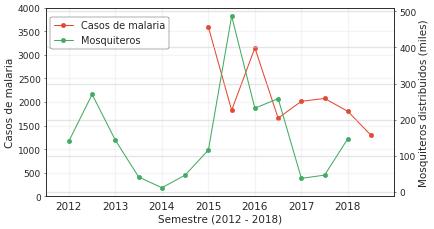

In [20]:
mlp.rcParams["figure.figsize"] = (9,5)
mlp.rcParams["figure.dpi"] = 50
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
notifsSemester.groupby("semindex").Notifs.sum().plot(label="Casos de malaria", marker="o", ax = ax1)
ax1.set_ylabel("Casos de malaria")
bednetsSemester.groupby("semindex")[0].sum().divide(1e3).plot(ax=ax2, color="#44ab63", label="Mosquiteros", marker="o")
ax2.set_ylabel("Mosquiteros distribuidos (miles)")
ax2.grid(alpha=0.5)
ax1.grid(alpha=0.2)
plt.title("")
ax1.set_xlabel("Semestre (2012 - 2018)")
plt.xticks(range(1,15,2), [2012, 2013, 2014, 2015, 2016, 2017, 2018])
fig.legend(loc='lower left', bbox_to_anchor=(0.1, 0.7))
plt.xlim(0,15)
ax1.set_ylim(0,4000)

In [21]:
bednetsYears = bednets\
    .groupby(["year", "CodDepto_e"]).Pabellones.sum().unstack(0).fillna(0)

In [22]:
bednetsYears

year,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
CodDepto_e,,,,,,,
2.0,0.0,0.0,0.0,5137.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,2500.0,346.0,0.0,0.0
5.0,63189.0,12661.0,25526.0,75481.0,41708.0,20000.0,17309.0
6.0,0.0,0.0,6243.0,8393.0,18250.0,0.0,0.0
7.0,0.0,0.0,0.0,6070.0,1936.0,422.0,0.0
9.0,0.0,0.0,0.0,19881.0,17263.0,446.0,4090.0
10.0,63795.0,47455.0,0.0,56722.0,69967.0,59.0,0.0
11.0,29615.0,28312.0,0.0,45595.0,37450.0,0.0,27937.0
12.0,19487.0,20463.0,50.0,25054.0,20518.0,0.0,0.0


In [23]:
bednetsSemester[bednetsSemester.CodDepto_e == 5]

,CodDepto_e,year,Semester,0,semindex
26,5.0,2012.0,1,53944.0,1.0
27,5.0,2012.0,2,9245.0,2.0
28,5.0,2013.0,1,834.0,3.0
29,5.0,2013.0,2,11827.0,4.0
30,5.0,2014.0,1,10633.0,5.0
31,5.0,2014.0,2,14893.0,6.0
32,5.0,2015.0,1,24401.0,7.0
33,5.0,2015.0,2,51080.0,8.0
34,5.0,2016.0,1,8146.0,9.0
35,5.0,2016.0,2,33562.0,10.0


# Weighted dose
As (Abrahamowicza 2005) suggests: 
$$ cum.dose(t_{current}) = \sum_{t \leq t_{current}}{dose(t) \times w(t_{current} - t)} $$

In [24]:
def weightFunction (dt, sigma):
    return( np.exp( - (dt**2)/(2* (sigma**2) ) ) )

def invWeightFunction_sigma (w, dt):
    return( np.sqrt( - (dt**2)/(2*np.log(w)) ) )

In [25]:
# for three years: 
sigma2 = invWeightFunction_sigma(0.5, 3)
print(sigma2)

2.547965400864057


In [26]:
# for three years: 
sigma3 = invWeightFunction_sigma(0.5, 6)
print(sigma3)

5.095930801728114


In [27]:
# for 5 years: 
sigma5 = invWeightFunction_sigma(0.5, 10)
print(sigma5)

8.493218002880191


In [28]:
# Calculate weights for 10 years
# for 1.5 years
w2 = [weightFunction(t, sigma2) for t in range(20,-1,-1)]
print(w2)
# for 3 years: 
w3 = [weightFunction(t, sigma3) for t in range(20,-1,-1)]
print(w3)
# for 5 years: 
w5 = [weightFunction(t, sigma5) for t in range(20,-1,-1)]
print(w5)

[4.177236667929939e-14, 8.420781453308248e-13, 1.4551915228366858e-11, 2.155720052046913e-10, 2.7375938226945685e-09, 2.98023223876953e-08, 2.781221960964482e-07, 2.224977568771586e-06, 1.5258789062500007e-05, 8.970547438205558e-05, 0.0004520872618590284, 0.001953125, 0.007233396189744457, 0.022964601441806235, 0.0625, 0.14581612994701457, 0.29163225989402913, 0.5, 0.7348672461377994, 0.9258747122872905, 1.0]
[0.0004520872618590284, 0.0009579395387391747, 0.001953125, 0.0038317581549566996, 0.007233396189744457, 0.013139006488339289, 0.022964601441806235, 0.038621702060290294, 0.0625, 0.09732059081705585, 0.14581612994701457, 0.21022410381342865, 0.29163225989402913, 0.3892823632682234, 0.5, 0.6179472329646446, 0.7348672461377994, 0.8408964152537145, 0.9258747122872905, 0.980930087668915, 1.0]
[0.0625, 0.08189958774114772, 0.10584316404531594, 0.1349035295630534, 0.16957554093095903, 0.21022410381342868, 0.2570284566640167, 0.30992692498474667, 0.36856730432277535, 0.43226861565393265,

In [31]:
bednetsSemester2 = bednetsSemester.groupby(["semindex", "CodDepto_e"])[0].sum().unstack(0).fillna(0)

In [32]:
bednetsSemester2_c = bednetsSemester2.copy()
bednetsSemester2_c.loc[:,7:] = 0

In [33]:
bednetsSemester2_c

semindex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CodDepto_e,,,,,,,,,,,,,
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,53944.0,9245.0,834.0,11827.0,10633.0,14893.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,6243.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,0.0,63795.0,47153.0,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11.0,0.0,29615.0,26912.0,1400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12.0,0.0,19487.0,6661.0,13802.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
cumBednets3 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets3.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w3[-i:] ) if i>0 else 0
# cumBednets3 counterfactual
cumBednets3_c = bednetsSemester2_c.copy()
for d, row in bednetsSemester2_c.iterrows():
    for i in range(0,len(row)+1):
        cumBednets3_c.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w3[-i:] ) if i>0 else 0

cumBednets5 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets5.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w5[-i:] ) if i>0 else 0
cumBednets2 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets2.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w2[-i:] ) if i>0 else 0

In [126]:
cum_bns_m45a = pd.Series()
for i in range(1,len(bednetsSemester_m5a)-1):
    cum_bns_m45a.loc[bednetsSemester_m5a.semindex[i] ] = np.dot( bednetsSemester_m5a[0].values[0:i], w3[-i:] ) if i>0 else 0

In [127]:
print(cumBednets3_c,)

semindex       1.0           2.0            3.0            4.0   \
CodDepto_e                                                        
2.0             0.0      0.000000       0.000000       0.000000   
4.0             0.0      0.000000       0.000000       0.000000   
5.0         53944.0  62160.292649   59848.084140   66566.123633   
6.0             0.0      0.000000       0.000000       0.000000   
7.0             0.0      0.000000       0.000000       0.000000   
9.0             0.0      0.000000       0.000000       0.000000   
10.0            0.0  63795.000000  109731.434943  105621.973694   
11.0            0.0  29615.000000   55962.244546   55218.570124   
12.0            0.0  19487.000000   25776.384618   38378.495832   
13.0            0.0      0.000000       0.000000       0.000000   
14.0            0.0  27153.000000   41802.194670   44562.042702   
15.0            0.0  24258.000000   23797.402067   22627.830631   
16.0            0.0      0.000000       0.000000       0.00000

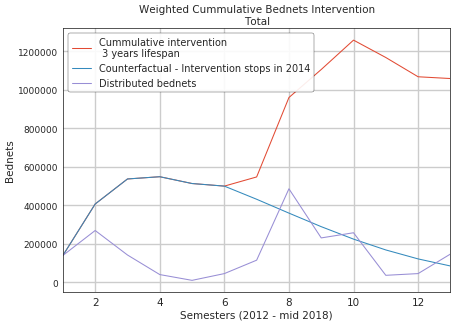

In [37]:
mlp.rcParams["figure.figsize"] = (10,7)
#cumBednets2.sum().plot(label="Cummulative intervention\n 2 years lifespan")
cumBednets3.sum().plot(label="Cummulative intervention\n 3 years lifespan")
#cumBednets5.sum().plot(label="Cummulative intervention\n 5 years lifespan")
cumBednets3_c.sum().plot(label="Counterfactual - Intervention stops in 2014")
bednetsSemester2.sum().plot(label="Distributed bednets")
plt.title("Weighted Cummulative Bednets Intervention\nTotal")
plt.ylabel("Bednets")
plt.xlabel("Semesters (2012 - mid 2018)")
plt.legend()

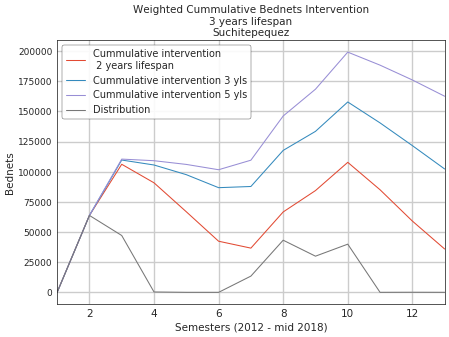

In [38]:
mlp.rcParams["figure.figsize"] = (10,7)
cumBednets2.loc[10].plot(label="Cummulative intervention\n 2 years lifespan")
cumBednets3.loc[10].plot(label="Cummulative intervention 3 yls")
cumBednets5.loc[10].plot(label="Cummulative intervention 5 yls")
bednetsSemester2.loc[10].plot(label="Distribution")
plt.title("Weighted Cummulative Bednets Intervention\n3 years lifespan\nSuchitepequez")
plt.ylabel("Bednets")
plt.xlabel("Semesters (2012 - mid 2018)")
plt.legend()

In [39]:
notifsSemester.groupby(["semindex", "deptocode"]).Notifs.sum().unstack(0).fillna(0)

semindex,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
deptocode,,,,,,,,
1,3,0,9,2,10,3,6,0
2,1,1,0,0,1,1,0,0
4,10,1,2,1,1,1,1,0
5,2676,909,2135,1063,1418,1020,1020,543
6,53,18,115,34,29,8,10,1
7,14,2,8,2,1,0,2,0
9,1,2,0,0,0,0,1,0
10,95,57,165,76,113,187,140,83
11,75,30,44,31,24,10,13,7


In [40]:
def lagBednet(i):
    def lagCalc(x):
        bednetsLag = bednetsSemester[(bednetsSemester.CodDepto_e == x.deptocode) &(bednetsSemester.semindex == (x.semindex - i))][[0]]
        bednetsLag2 = bednetsSemester[(bednetsSemester.CodDepto_e == x.deptocode) &(bednetsSemester.semindex == (x.semindex - i - 1))][[0]]
        
        if len(bednetsLag) == 1:
            return bednetsLag2.values[0][0]+bednetsLag.values[0][0]
        else:
            return 0
    return lagCalc

for i in range(1,5):
    notifsSemester["bednetsLagSem_"+str(i)] = notifsSemester.apply(lagBednet(i), axis = 1)

In [41]:
def lagNotifs(i):
    def lagCalc(x):
        notifsLag = notifsSemester[(notifsSemester.deptocode == x.deptocode) &(notifsSemester.semindex == (x.semindex - i))].Notifs
        if len(notifsLag) == 1:
            return notifsLag.values[0]
        else:
            return 0
    return lagCalc

for i in range(1,5):
    notifsSemester["notifsLagSem_"+str(i)] = notifsSemester.apply(lagNotifs(i), axis = 1)

In [42]:
# Counterfactual bednet distribution
notifsSemester = notifsSemester\
        [[x for x in notifsSemester.columns if ( (not x.endswith("_y")) & (not x.endswith("_x")) &
         (not x.startswith("cumBN") ))]]

notifsSemester = notifsSemester.merge(cumBednets3.stack().rename("cumBN").reset_index(), how="left",
                     left_on=["deptocode", "semindex"],
                    right_on = ["CodDepto_e", "semindex"])
notifsSemester.loc[notifsSemester["cumBN"].isna() ,"cumBN"] = 0

In [51]:
cumBednets3_c.sum()

semindex
1.0     140396.000000
2.0     407702.660588
3.0     537677.534895
4.0     549323.657252
5.0     513989.966998
6.0     500563.392267
7.0     432297.571803
8.0     360349.869053
9.0     289975.569594
10.0    225305.460076
11.0    169056.551952
12.0    122522.681515
13.0     85781.832273
dtype: float64

In [43]:
notifsSemester = notifsSemester.merge(cumBednets3_c.stack().rename("cumBN_cf").reset_index(), how="left",
                     left_on=["deptocode", "semindex"],
                    right_on = ["CodDepto_e", "semindex"])
notifsSemester.loc[notifsSemester["cumBN_cf"].isna() ,"cumBN_cf"] = 0

In [44]:
def lagCol(i, col, df):
    def lagCalc(x):
        cumLag = df[(notifsSemester.deptocode == x.deptocode) &(notifsSemester.semindex == (x.semindex - i))][col]
        if len(cumLag) == 1:
            return cumLag.values[0]
        else:
            return 0
    return lagCalc

In [45]:
for i in range(1,5):
    notifsSemester["cumBNLagSem_"+str(i)] = notifsSemester.apply(lagCol(i, "cumBN", notifsSemester), axis = 1)
for i in range(1,5):
    notifsSemester["cumBN_cf_LagSem_"+str(i)] = notifsSemester.apply(lagCol(i, "cumBN_cf", notifsSemester), axis = 1)

In [46]:
notifsSemester.semindex.value_counts()

14.0    19
13.0    19
12.0    19
11.0    19
10.0    19
9.0     19
8.0     19
7.0     19
Name: semindex, dtype: int64

In [47]:
notifsSemester.to_csv(base_dir + "Gtm Malaria impact analysis data.csv")

In [55]:
notifsSemester.groupby("semindex").cumBN_cf.sum()

semindex
7.0     419944.297602
8.0     350711.085772
9.0     282738.251083
10.0    220076.080325
11.0    165420.404690
12.0    120089.618389
13.0     84215.125048
14.0         0.000000
Name: cumBN_cf, dtype: float64

In [151]:
plotdata = pd.read_csv("../../Impact Evaluation/wce_impact_eval_model4_counterfactual.csv")

In [152]:
plotdata

,Unnamed: 0,semindex,variable,value
0,1,7,cfci1,NaN
1,2,8,cfci1,1.693226e+03
2,3,9,cfci1,2.795507e+03
3,4,10,cfci1,1.921294e+03
4,5,11,cfci1,2.339776e+03
5,6,12,cfci1,1.615966e+03
6,7,13,cfci1,1.741308e+03
7,8,7,cfci2,NaN
8,9,8,cfci2,2.120923e+03
9,10,9,cfci2,3.417900e+03


(-0.5, 6.5)

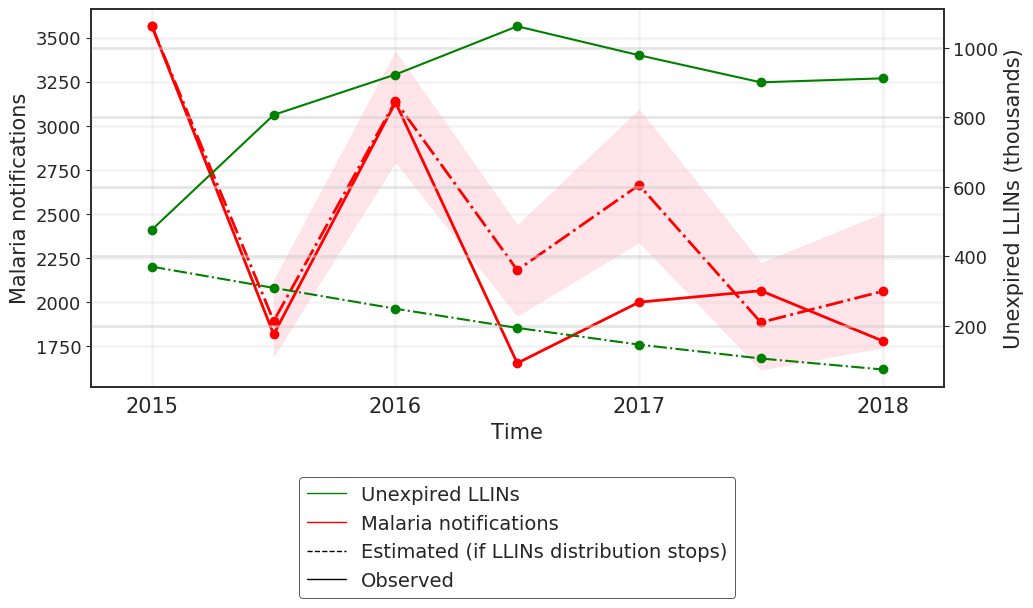

In [153]:
mlp.rcParams["figure.figsize"] = (11,5)
mlp.rcParams["figure.dpi"] = 100
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_ylabel("Malaria notifications")
ax2.set_ylabel("Unexpired LLINs (thousands)")

ax1.fill_between(list(range(0,7)), plotdata[plotdata.variable == "cfci1"].value, plotdata[plotdata.variable == "cfci2"].value,
                    alpha=0.4, color="pink"
                )
plotdata[plotdata.variable == "f"].reset_index().value.plot(marker="o", ax = ax1, color="red", lw=2)
plotdata[plotdata.variable == "cf"].reset_index().value.plot(marker="o", ax = ax1, color="red", lw=2, linestyle="-.")

plotdata[plotdata.variable == "bnf"].reset_index().value.divide(1000)\
.plot(marker="o", ax = ax2, color="green")
plotdata[plotdata.variable == "bncf"].reset_index().value.divide(1000)\
.plot(marker="o", ax = ax2, color="green", linestyle="-.")

legend_elements = [
    mlp.lines.Line2D([0], [0], color='green', lw=1, label='Unexpired LLINs'),
    mlp.lines.Line2D([0], [0], color='red', lw=1, label='Malaria notifications'),
    mlp.lines.Line2D([0], [0], color='black', linestyle="--", lw=1, label='Estimated (if LLINs distribution stops)'),
    mlp.lines.Line2D([0], [0], color='black', linestyle="-",  lw=1, label='Observed')
]
plt.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.4))

ax2.grid(alpha=0.5)
ax1.grid(alpha=0.2)
plt.title("")
ax1.set_xlabel("Time")
plt.xticks(range(0,8,2), [2015, 2016, 2017, 2018])
plt.xlim(-0.5,6.5)

In [141]:
(list(range(0,6)), plotdata[plotdata.variable == "cfci1"].value, plotdata[plotdata.variable == "cfci2"].value)

([0, 1, 2, 3, 4, 5], 0            NaN
 1    1761.343841
 2    2790.415283
 3    1929.307806
 4    2272.051721
 5    1637.099964
 6    1801.153109
 Name: value, dtype: float64, 7             NaN
 8     2097.972660
 9     3425.333331
 10    2369.089207
 11    3208.806763
 12    2160.774359
 13    2448.941108
 Name: value, dtype: float64)